# Given the CSV of labels information
## Restructure for consistency with column's in Galen's scripts for ease of cropping

```
gsv_panorama_id,sv_image_x,sv_image_y,label_type_id,photagrapher_heading,heading,is_researcher

stxXyCKAbd73DmkM2vsIHA,9676,-455,1,50.4137916565,253.375,t
```

## Comments
* Need to merge with metadata file to get the gsv_panorama_id
* Want to keep an image id as well
* sv_image_x and sv_image_y 
* 

In [1]:
import pandas as pd
import os
import s3fs # for reading from S3FileSystem
import json # for working with JSON files 

import matplotlib.pyplot as plt

pd.set_option('max_colwidth', -1)

# Load current Labels CSV

In [2]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'
df_labels = pd.read_csv('all_labels_bool.csv')
print(df_labels.shape)
print(df_labels.dtypes)
df_labels.head()

(3440, 14)
filename                   object
file_size                  int64 
file_attributes            object
region_count               int64 
region_id                  int64 
region_shape_attributes    object
region_attributes          object
img_id                     int64 
present_ramp               bool  
missing_ramp               bool  
obstacle                   bool  
surface_prob               bool  
no_sidewalk                bool  
null                       bool  
dtype: object


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False


# Limit to where there's exactly 1 region_attribute on a point

In [3]:
# Find the roughly 26 rows where there are multiple attributes in a given tag
df_limit = df_labels.loc[(~df_labels['region_attributes'].str.contains(',')) & (df_labels['region_attributes'] != '{}')].copy()
# Find where no tags were given to an image
#df_limit = df_.loc[df_labels['region_attributes'] != '{}']
df_limit.shape

(2851, 14)

## Parse out x and y coordinates
## Name as sv_image_x and sv_image_y

In [4]:
df_coor = df_limit['region_shape_attributes'].str.extract('{"name":"point","cx":(.*),"cy":(.*)}')
df_coor.columns = ['sv_image_x', 'sv_image_y']
df_coor['sv_image_x'] = pd.to_numeric(df_coor['sv_image_x'])
df_coor['sv_image_y'] = pd.to_numeric(df_coor['sv_image_y'])
df_coor.head()

,sv_image_x,sv_image_y
0,108,389
1,160,389
2,607,453
3,18,475
4,245,413


In [5]:
df_coor.describe()

,sv_image_x,sv_image_y
count,2851.000000,2851.000000
mean,315.844967,410.083129
std,152.674854,47.643785
min,2.000000,325.000000
25%,208.500000,377.000000
50%,317.000000,404.000000
75%,422.000000,430.000000
max,634.000000,634.000000


In [6]:
coor_cols = ['sv_image_x', 'sv_image_y']
df_limit[coor_cols] = df_coor[coor_cols]
df_limit.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null,sv_image_x,sv_image_y
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False,108,389
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,160,389
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,607,453
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,18,475
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,245,413


In [7]:
df_limit['sv_image_y_bottom_origin'] = 640 - df_limit['sv_image_y']

In [8]:
feature_cols = ['present_ramp', 'missing_ramp', 'obstacle', 'surface_prob', 'no_sidewalk', 'null']
df_limit[feature_cols].sum()

present_ramp    1677
missing_ramp    124 
obstacle        147 
surface_prob    448 
no_sidewalk     430 
null            0   
dtype: int64

In [18]:
df_limit['label_name'] = df_limit['region_attributes'].str.split('":', expand = True)[0].str.strip('{"')
df_limit['label_name'].value_counts()

Present Curb Ramp    1677
Surface Problem      448 
No Sidewalk          430 
Obstacle             147 
Missing Curb Ramp    124 
Occlusion            25  
Name: label_name, dtype: int64

In [19]:
df_limit.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null,sv_image_x,sv_image_y,sv_image_y_bottom_origin,label_name
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False,108,389,251,Present Curb Ramp
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,160,389,251,Present Curb Ramp
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,607,453,187,Present Curb Ramp
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,18,475,165,Present Curb Ramp
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,245,413,227,Present Curb Ramp


In [20]:
df_limit.to_csv('restructure_single_labels.csv', index = False)

# Plot Prediction Locations in Images

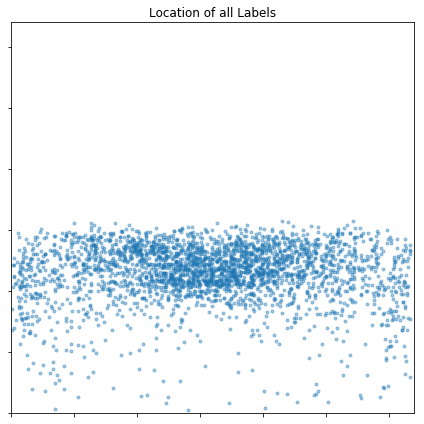

In [10]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
x = df_limit['sv_image_x']
#y = 640 - df_limit['sv_image_y']
y = df_limit['sv_image_y_bottom_origin']
plt.plot(x, y, marker = '.', ls = 'none', alpha = 0.4)
plt.ylim(0, 640)
plt.xlim(0, 640)
plt.title('Location of all Labels')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.tight_layout()

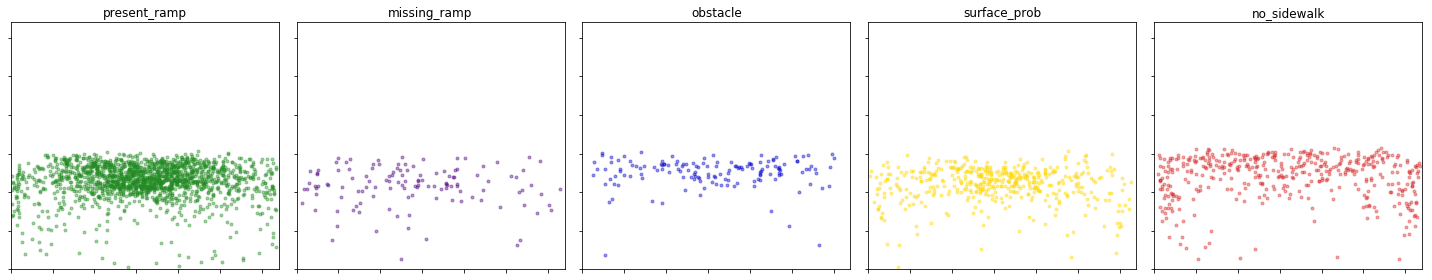

In [14]:
fig = plt.figure(figsize = (20, 4))

colors_list = ['forestgreen', 'indigo', 'mediumblue', 'gold', 'tab:red']

for index in range(5):
    ax = fig.add_subplot(1, 5, int(index+1))
    column_name = feature_cols[index]
    x = df_limit['sv_image_x'].loc[df_limit[column_name]]
    y = df_limit['sv_image_y_bottom_origin'].loc[df_limit[column_name]]
    ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[index])
    plt.ylim(0, 640)
    plt.xlim(0, 640)
    plt.title(column_name)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.tight_layout()

In [12]:
df_limit.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null,sv_image_x,sv_image_y,sv_image_y_bottom_origin
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False,108,389,251
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,160,389,251
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,607,453,187
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,18,475,165
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,245,413,227


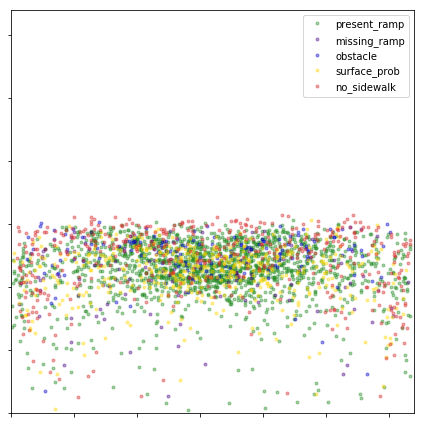

In [23]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
colors_list = ['forestgreen', 'indigo', 'mediumblue', 'gold', 'tab:red']

for index in range(5):
    
    column_name = feature_cols[index]
    x = df_limit['sv_image_x'].loc[df_limit[column_name]]
    y = df_limit['sv_image_y_bottom_origin'].loc[df_limit[column_name]]
    ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[index], label = column_name)
    plt.ylim(0, 640)
    plt.xlim(0, 640)
    #plt.title(column_name)
    plt.legend(loc = 'best')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.tight_layout()